In [1]:
import tifffile as tf
from scipy import ndimage, signal, spatial

import numpy as np
import pandas as pd
import os

import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [2]:
from shapely.geometry import LineString, Polygon
from shapely.ops import polylabel

In [3]:
ang = np.linspace(0, 2*np.pi, 200, endpoint=True)
circle = np.vstack((np.sin(ang), np.cos(ang)))

In [4]:
src = '../hpcc/'
dst = '../hpcc/kernel/'

wsrc = src + 'clean/'
tsrc = src + 'watershed/'
rsrc = src + 'rotated/'

fs = 15
resol = 0.0759

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

mborder2 = ndimage.generate_binary_structure(2, 1).astype(int)
mborder2[mborder2 == 1] = -1
mborder2[1,1] = -np.sum(mborder2) - 1

In [5]:
idname = 'GB'

rownum = 5
treenum = 3
nutnum = 7

bname = idname + '_R{}_T{}'.format(rownum, treenum)
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
print(wdst)

GB_R5_T3_007
../hpcc/kernel/GB_R5_T3/


In [6]:
tissuefiles = tsrc + bname + '/' + fname + '_'
meat = tf.imread(tissuefiles + 'meat.tif')

bimg = meat.copy().astype(int)
bimg[bimg > 0]  = 1
kervol = np.sum(bimg)*(resol**3)
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
kerarea = np.sum(border) * (resol ** 2)
border[border > 0] = 1

In [7]:
filename = rsrc + bname + '/' + fname + '_rotation.csv'
data = np.loadtxt(filename, delimiter=',')

wmean = data[0]
rotxyz = data[10:13]
rotX, _, _ = data[13]
tipvox = data[14]
rtipvox = data[15]

tipvox[0] *= 1 + (-2*rotX)

datapoints = np.asarray(np.nonzero(border))
#datapoints = datapoints - np.mean(datapoints, axis=1).reshape(-1,1)
datapoints = datapoints - wmean.reshape(-1,1)
datapoints *= resol

mcoords = rotxyz @ datapoints
khull = spatial.ConvexHull(mcoords.T)

kk = 0
phalfx = mcoords[:, mcoords[0] >  kk]
nhalfx = mcoords[:, mcoords[0] < -kk]

kk = 1
phalfy = mcoords[:, mcoords[1] >  kk]
nhalfy = mcoords[:, mcoords[1] < -kk]

kk = 1
phalfz = mcoords[:, mcoords[2] >  kk]
nhalfz = mcoords[:, mcoords[2] < -kk]

kk = 1
halfy = mcoords[:, np.abs(mcoords[1]) <  kk]
halfz = mcoords[:, np.abs(mcoords[2]) <  kk]

In [8]:
kminis = np.min(mcoords, axis=1)
kmaxes = np.max(mcoords, axis=1)

c,b,a = np.sort(kmaxes - kminis)*.5

krumbein = np.cbrt(b*c/(a*a))
corey = c/np.sqrt(a*b)
sneed = np.cbrt(c*c/(a*b))
janke = c/np.sqrt((a**2 + b**2 + c**2)/3)

print('{:.2f}\t{:.2f}\t{:.2f}'.format(a,b,c))
print(np.round([krumbein, corey, sneed, janke, c/a],3), sep='\t')

15.71	14.76	12.92
[0.918 0.849 0.897 0.891 0.823]


In [9]:
charearatio = kerarea/khull.area
chivolratio = khull.volume/kervol

In [10]:
kk = 1
mask = (np.abs(mcoords[1]) <= kk) & (np.abs(mcoords[2]) <= kk)
spine = mcoords[:, mask]
outer = mcoords[:, ~mask]

# Bottom clamp

In [11]:
kk = 1
aux = 1
mask = (mcoords[0] < -kk) & (mcoords[1] > kk) & (mcoords[2] > kk)
foo = mcoords.copy() ; foo[:, ~mask] = 0
bar = np.abs(foo[0]) - aux*(np.abs(foo[1]))
leg0x, leg0y, leg0z = mcoords[:, np.argmax(bar)]

mask = (mcoords[0] < -kk) & (mcoords[1] < -kk) & (mcoords[2] > kk)
foo = mcoords.copy() ; foo[:, ~mask] = 0
bar = np.abs(foo[0]) - aux*(np.abs(foo[1]))
leg1x, leg1y, leg1z = mcoords[:, np.argmax(bar)]

mask = (mcoords[0] < -kk) & (mcoords[1] < -kk) & (mcoords[2] < -kk)
foo = mcoords.copy() ; foo[:, ~mask] = 0
bar = np.abs(foo[0]) - aux*(np.abs(foo[1]))
leg2x, leg2y, leg2z = mcoords[:, np.argmax(bar)]

mask = (mcoords[0] < -kk) & (mcoords[1] > kk) & (mcoords[2] < -kk)
foo = mcoords.copy() ; foo[:, ~mask] = 0
bar = np.abs(foo[0]) - aux*(np.abs(foo[1]))
leg3x, leg3y, leg3z = mcoords[:, np.argmax(bar)]

legx = np.asarray([leg0x, leg1x, leg2x, leg3x])
legy = np.asarray([leg0y, leg1y, leg2y, leg3y])
legz = np.asarray([leg0z, leg1z, leg2z, leg3z])
print('X:\t', legx, '\nY:\t', legy, '\nZ:\t', legz, sep='')

X:	[-15.17349523 -15.01235705 -14.766946   -14.19294178]
Y:	[ 3.69650657 -2.08669745 -1.00853653  1.02047501]
Z:	[ 1.6114659   1.04956163 -3.38442966 -2.53188128]


13.498803877034364	1.141926335768277	12.356877541266087


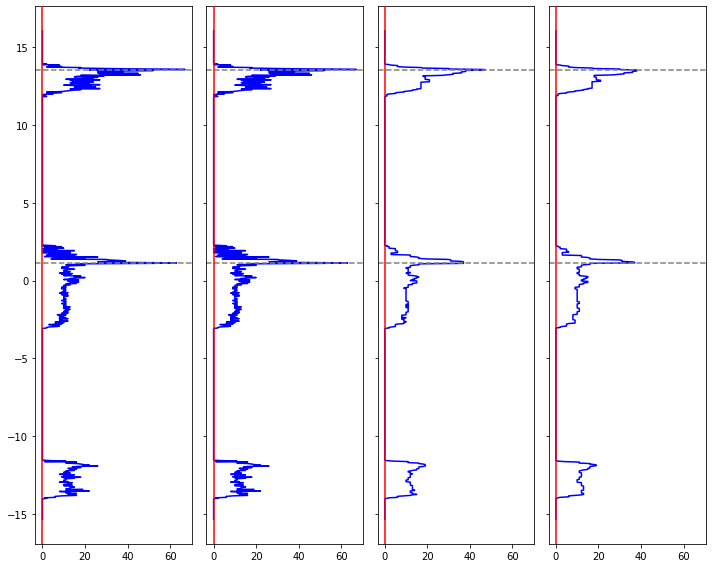

In [12]:
# central bit

kk = 1
hist, bins = np.histogram(spine[0], bins=np.linspace(kminis[0], kmaxes[0], 1000), density = False)
hist0 = hist.copy()
fhist = ndimage.median_filter(hist, size=5, mode='constant', cval=0)
mhistc = ndimage.minimum_filter1d(fhist, size=3, mode='constant', cval=0)

peaks, _ = signal.find_peaks(mhistc, height=np.max(mhistc)*.33, prominence=np.max(mhistc)*.33, wlen=50)
if len(peaks) < 2:
    peaks, _ = signal.find_peaks(hist0, height=np.max(hist0)*.33, prominence=np.max(hist0)*.33, wlen=50)
if len(peaks) < 2:
    peaks, _ = signal.find_peaks(hist0, height=np.max(hist0)*.33, prominence=np.max(hist0)*.33, wlen=50)

zeros = bins[peaks+1]
htop = np.max(zeros)
foo = np.argmin(np.abs(zeros))
hbot = zeros[foo]

if hbot < -4:
    hbot = 0

if htop < hbot + 5:
    htop = bins[np.nonzero(mhistc)[0][-1]]
hlength = htop - hbot

print(htop, hbot, hlength, sep='\t')

fig, ax = plt.subplots(1,4,figsize=(10,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel() ; i = 0
ax[i].plot(hist0, bins[1:],c='b'); i += 1
ax[i].plot(hist, bins[1:],c='b'); i += 1
ax[i].plot(fhist, bins[1:],c='b'); i += 1
ax[i].plot(mhistc, bins[1:],c='b')

for i in range(len(ax)):
    ax[i].axvline(0, c='r', zorder=9)
    for z in zeros:
        ax[i].axhline(z, c='gray', ls='--')

fig.tight_layout();

In [13]:
# lower arch height
atop = hbot
abot = np.median(legx)
alength = atop - abot
print(atop, abot, alength, sep='\t')

1.141926335768277	-14.889651527896504	16.03157786366478


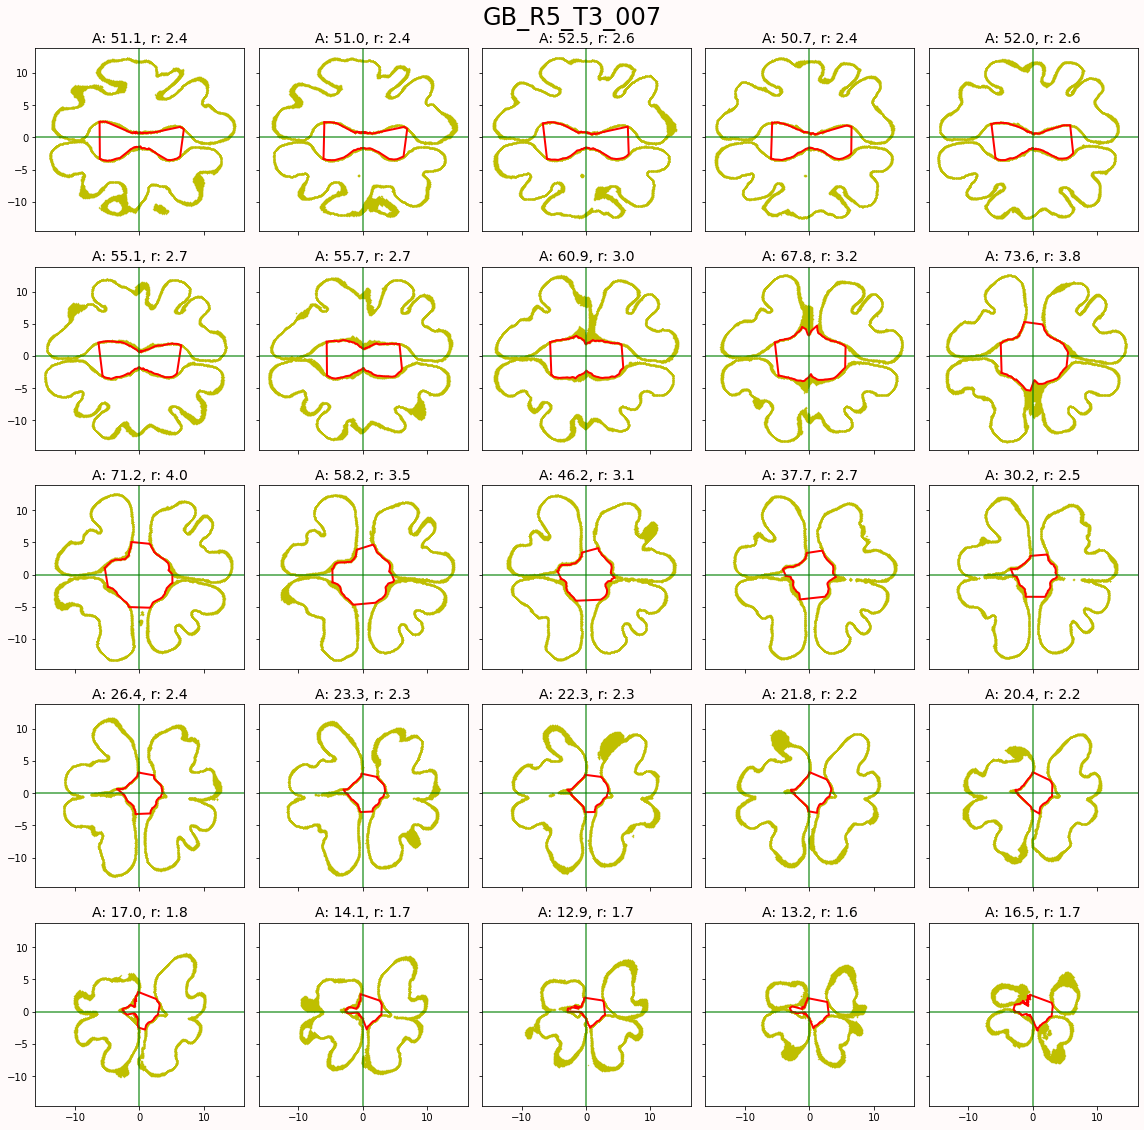

In [16]:
linspace = np.linspace(atop-1, abot+1, 25)
eps = (linspace[0] - linspace[1])/2
granularity = 100
bins = np.linspace(-np.pi, np.pi, granularity+1)

surface = np.zeros(len(linspace))
volume = np.zeros_like(surface)
distantpoles = np.zeros_like(volume)
distantpolev = np.zeros_like(volume)

fs = 14
fig, ax = plt.subplots(5,5,figsize=(16,16), sharex=True, sharey=True, facecolor='snow')
ax = np.atleast_1d(ax).ravel(); i = 0

for i in range(len(linspace)):
    kk = linspace[i]
    nhalfx = mcoords[:, (mcoords[0] < kk + eps) & (mcoords[0] > kk - eps)]
    #nhalfx = nhalfx - np.mean(nhalfx, axis=1).reshape(-1,1)

    if nhalfx.shape[1] > 10:
    
        data = nhalfx[1:]
        angles = np.angle(data[0] + data[1]*1j)

        binning = np.digitize(angles, bins)

        trace = np.zeros((granularity, 2))
        for j in range(granularity):
            if np.sum(binning == j + 1) > 1:
                subdata = data[:, binning == j + 1]
                arg = np.argmin(np.sqrt(np.sum(subdata**2, axis=0)))
                trace[j] = subdata[:, arg]
        trace = trace[np.all(trace, axis=1),:].T
        radii = np.sqrt(np.sum(trace**2, axis=0))
        mr = np.quantile(radii, 0.8)

        trace = trace[:, radii < mr]
        polygon = Polygon(zip(*trace))
        if not polygon.is_valid:
            polygon = polygon.buffer(0)
        if polygon.geom_type == 'Polygon':
            center = polylabel(polygon, tolerance=1e-1)
        rr = np.min(np.sqrt((trace[0] - center.x)**2 + (trace[1] - center.y)**2))

        surface[i] = polygon.length*eps
        volume[i] = polygon.area*eps
        distantpoles[i] = 4*np.pi*rr**2
        distantpolev[i] = 4/3*np.pi*rr**3

        ax[i].set_title('A: {:.1f}, r: {:.1f}'.format(polygon.area, rr), fontsize=fs)
        ax[i].scatter(nhalfx[1], nhalfx[2], s=0.5, color='y', alpha=1, marker='.');
        ax[i].plot(trace[0], trace[1], c='r', lw=2)
        ax[i].plot([trace[0,0],trace[0,-1]], [trace[1,0],trace[1,-1]], c='r', lw=2)
        #ax[i].scatter([center.x], [center.y], s=50, c='k')
        #ax[i].plot(rr*circle[0] + center.x, rr*circle[1]+center.y, lw=2, c='k', zorder=5)

for i in range(len(ax)):
    ax[i].set_aspect('equal');
    ax[i].axvline(0, c='g',alpha=0.75)
    ax[i].axhline(0,c='g',alpha=0.75);

fig.suptitle(fname, fontsize=fs+10)
fig.tight_layout();

../../writing/walnut_figs/GB_R5_T3_007_kernel_02.jpg


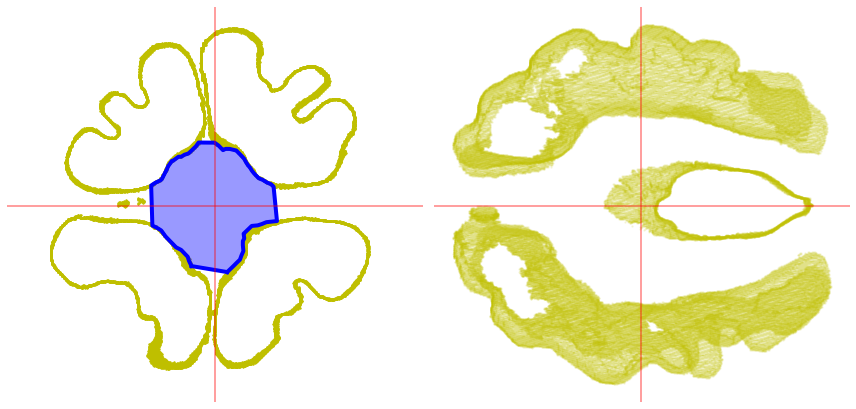

In [50]:
fs = 14
fig, ax = plt.subplots(1,2,figsize=(12,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

kk = linspace[10]
nhalfx = mcoords[:, (mcoords[0] < kk + eps) & (mcoords[0] > kk - eps)]

data = nhalfx[1:]
angles = np.angle(data[0] + data[1]*1j)

binning = np.digitize(angles, bins)

trace = np.zeros((granularity, 2))
for j in range(granularity):
    if np.sum(binning == j + 1) > 1:
        subdata = data[:, binning == j + 1]
        arg = np.argmin(np.sqrt(np.sum(subdata**2, axis=0)))
        trace[j] = subdata[:, arg]
trace = trace[np.all(trace, axis=1),:].T
radii = np.sqrt(np.sum(trace**2, axis=0))
mr = np.quantile(radii, 0.8)

trace = trace[:, radii < mr]
polygon = Polygon(zip(*trace))
if not polygon.is_valid:
    polygon = polygon.buffer(0)
if polygon.geom_type == 'Polygon':
    center = polylabel(polygon, tolerance=1e-1)
rr = np.min(np.sqrt((trace[0] - center.x)**2 + (trace[1] - center.y)**2))

surface[i] = polygon.length*eps
volume[i] = polygon.area*eps
distantpoles[i] = 4*np.pi*rr**2
distantpolev[i] = 4/3*np.pi*rr**3

ax[i].scatter(nhalfx[2], nhalfx[1], s=2, color='y', alpha=1, marker='o');
ax[i].fill(trace[1], trace[0], c='b', alpha=.4)
ax[i].plot([trace[1,0],trace[1,-1]], [trace[0,0],trace[0,-1]], c='b', lw=4)
ax[i].plot(trace[1], trace[0], c='b', lw=4)

i += 1
ax[i].scatter(halfz[0], halfz[1], s=2, color='y', alpha=.1, marker='o')

for i in range(len(ax)):
    ax[i].set_aspect('equal');
    ax[i].axvline(0, c='r',alpha=0.5)
    ax[i].axhline(0,c='r',alpha=0.5);
    ax[i].axis('off')

fig.tight_layout()

filename = '../../writing/walnut_figs/' + fname + '_kernel_02.jpg'
print(filename)
plt.savefig(filename, dpi=200, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})

In [97]:
vol = np.sum(volume)
suf = np.sum(surface)
print(vol, suf, vol/suf)

0.0 0.0 nan


../hpcc/kernel/2014SBa_R5_T87/2014SBa_R5_T87_001_kernel.jpg


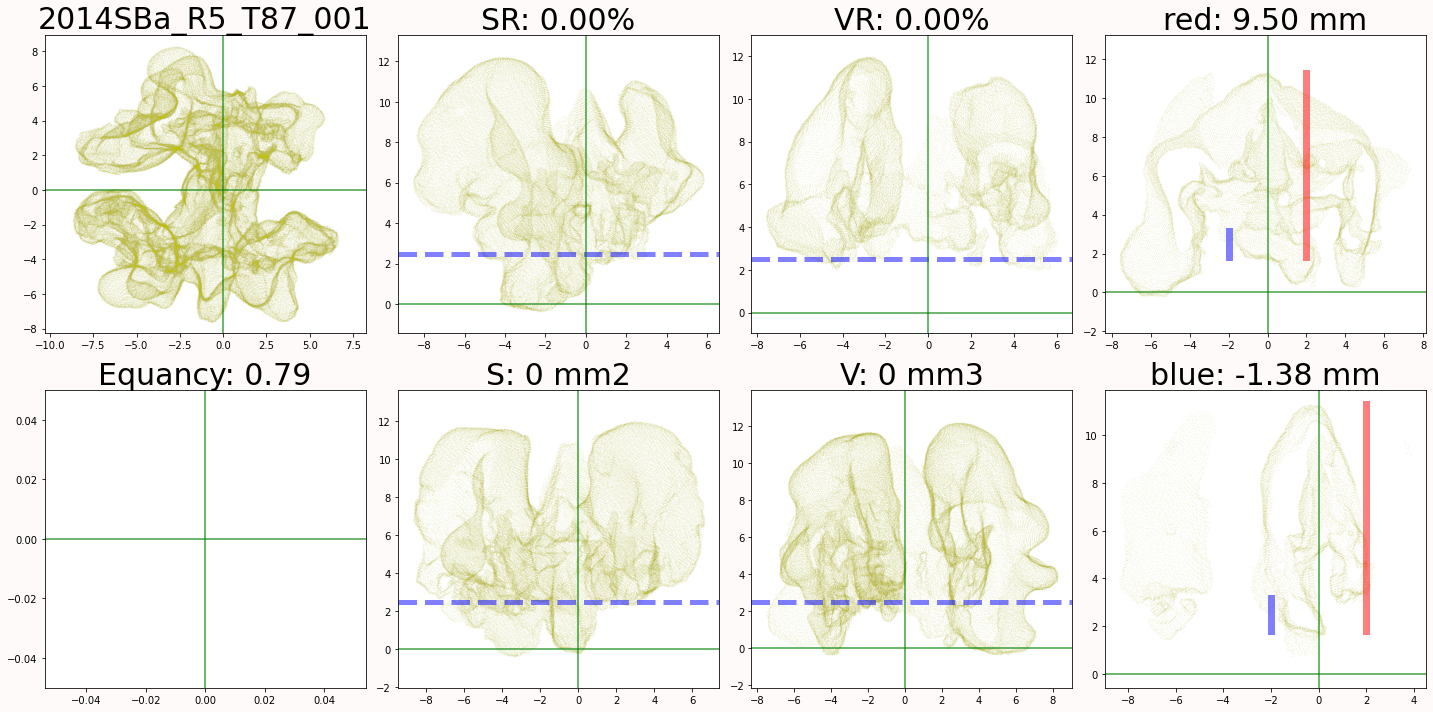

In [105]:
fs = 30

fig, ax = plt.subplots(2,4,figsize=(20,10), sharex=False, sharey=False, facecolor='snow')
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(phalfx[1], phalfx[2], s=.1, color='y', alpha=.2, marker='.')
ax[i].set_title(fname, fontsize=fs)
i += 1
ax[i].scatter(phalfz[1], phalfz[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].axhline(np.mean([atop,abot]), c='b', lw=5, ls='--', alpha=.5)
ax[i].set_title('SR: {:.2f}%'.format(100*suf/kerarea), fontsize=fs)
i += 1
ax[i].scatter(phalfy[2], phalfy[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].axhline(np.mean([atop,abot]), c='b', lw=5, ls='--', alpha=.5)
ax[i].set_title('VR: {:.2f}%'.format(100*vol/khull.volume), fontsize=fs)
i += 1
ax[i].scatter(halfy[2], halfy[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].plot([2,2], [htop, hbot], lw=7, c='r', alpha=.5)
ax[i].plot([-2,-2], [atop, abot], lw=7, c='b', alpha=0.5)
ax[i].set_title('red: {:.2f} mm'.format(hlength), fontsize=fs)
i += 1

######

ax[i].scatter(nhalfx[1], nhalfx[2], s=.1, color='y', alpha=.2, marker='.')
ax[i].scatter(trace[0], trace[1], s=10, zorder=4, c='r', marker='*')
ax[i].set_title('Equancy: {:.2f}'.format(c/a), fontsize=fs)
i += 1
ax[i].scatter(nhalfz[1], nhalfz[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].axhline(np.mean([atop,abot]), c='b', lw=5, ls='--', alpha=.5)
ax[i].set_title('S: {:.0f} mm2'.format(suf), fontsize=fs)
i += 1
ax[i].scatter(nhalfy[2], nhalfy[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].axhline(np.mean([atop,abot]), c='b', lw=5, ls='--', alpha=.5)
ax[i].set_title('V: {:.0f} mm3'.format(vol), fontsize=fs)
i += 1
ax[i].scatter(halfz[1], halfz[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].plot([2,2], [htop, hbot], lw=7, c='r', alpha=.5)
ax[i].plot([-2,-2], [atop, abot], lw=7, c='b', alpha=0.5)
ax[i].set_title('blue: {:.2f} mm'.format(alength), fontsize=fs)
i += 1

for i in range(len(ax)):
    ax[i].set_aspect('equal', 'datalim');
    ax[i].axvline(0, c='g',alpha=0.75)
    ax[i].axhline(0,c='g',alpha=0.75);
fig.tight_layout();

filename = wdst + fname + '_kernel.jpg'
print(filename)
#plt.savefig(filename, dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})

In [22]:
kerpheno = [kerarea, kervol, charearatio, chivolratio, krumbein,
            corey, sneed, janke, c/a, suf, vol, hlength, alength]
filename = wdst + fname + '_kernel.csv'
print(filename)
foo = pd.DataFrame([bname, fname.split('_')[-1], *kerpheno]).T
foo.to_csv(filename, header=False, index=False)

../hpcc/kernel/NewStuke_R1_T18/NewStuke_R1_T18_006_kernel.csv
